In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Thu Jan 25 18:49:10 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   44C    P0    47W / 300W |     35MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [3]:
from model.main.enc_prior_latent_quantizer_dec import Model
from model.encoder.net_64_encoder import Encoder
from model.latent.vqvae_latent import Latent
from model.decoder.net_64_decoder import Decoder
from model.no_module import NoModule

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.img_size = 64
hp.n_resblocks = 6
hp.n_latents = 512
hp.z_dim = 64

In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), NoModule(**hp), Latent(**hp), NoModule(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 1.2191162109375
encoder.encoder 1.2191162109375
prior 0.0
latent 0.0
latent.bottle 0.0
quantizer 0.0
decoder 1.0611686706542969
decoder.decoder 1.0611686706542969
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train_dalle/train01.21-1_2/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model_list, optimizer_list = load_model_list(save_dir, 100000, model_list, optimizer_list)

total 7360
-rw-rw-r-- 1 scpark scpark   45363  1월 25 18:49 events.out.tfevents.1706176009.GPUSVR11
-rw-rw-r-- 1 scpark scpark 7468351  1월 25 18:47 save_0
-rw-rw-r-- 1 scpark scpark      40  1월 25 18:46 events.out.tfevents.1706175712.GPUSVR11
-rw-rw-r-- 1 scpark scpark      40  1월 25 18:46 events.out.tfevents.1706175916.GPUSVR11
-rw-rw-r-- 1 scpark scpark      40  1월 25 18:46 events.out.tfevents.1706175963.GPUSVR11
-rw-rw-r-- 1 scpark scpark    1437  1월 25 18:46 events.out.tfevents.1706175973.GPUSVR11


In [7]:
!ls -lt /data/scpark/save/lse/train_dalle/train01.19-7_tanh_0.99

total 235312
-rw-rw-r-- 1 scpark scpark 39017948  1월 25 18:41 events.out.tfevents.1706151103.GPUSVR11
-rw-rw-r-- 1 scpark scpark  7479121  1월 25 18:38 save_260000
-rw-rw-r-- 1 scpark scpark  7479121  1월 25 18:22 save_250000
-rw-rw-r-- 1 scpark scpark  7479121  1월 25 18:07 save_240000
-rw-rw-r-- 1 scpark scpark  7479121  1월 25 17:51 save_230000
-rw-rw-r-- 1 scpark scpark  7479121  1월 25 17:35 save_220000
-rw-rw-r-- 1 scpark scpark  7479121  1월 25 17:20 save_210000
-rw-rw-r-- 1 scpark scpark  7479121  1월 25 17:04 save_200000
-rw-rw-r-- 1 scpark scpark  7479121  1월 25 16:49 save_190000
-rw-rw-r-- 1 scpark scpark  7479121  1월 25 16:33 save_180000
-rw-rw-r-- 1 scpark scpark  7479121  1월 25 16:17 save_170000
-rw-rw-r-- 1 scpark scpark  7479121  1월 25 16:01 save_160000
-rw-rw-r-- 1 scpark scpark  7479121  1월 25 15:46 save_150000
-rw-rw-r-- 1 scpark scpark  7479121  1월 25 15:30 save_140000
-rw-rw-r-- 1 scpark scpark  7479121  1월 25 15:15 save_130000
-rw-rw-r-- 1 scpark scpark  7479121  1월 25 1

In [8]:
path = '/data/scpark/save/lse/train_dalle/train01.19-7_tanh_0.99/save_260000'
checkpoint = torch.load(path, map_location=torch.device('cpu'))
# warm start
for i, (model, optimizer) in enumerate(zip(model_list, optimizer_list)):
    model.load_state_dict(checkpoint['models_state_dict'][i], strict=False)
    #optimizer.load_state_dict(checkpoint['optimizers_state_dict'][i])
    
print('done')

done


### Dataset

In [9]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.img_size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
print('done')

done


In [10]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [11]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [12]:
def linear(start_value, end_value, current_index, start_index, end_index):
    if current_index > end_index:
        return end_value
    if current_index < start_index:
        return start_value

    grad = (end_value - start_value) / (end_index - start_index)
    y = start_value + grad * (current_index - start_index)

    return y

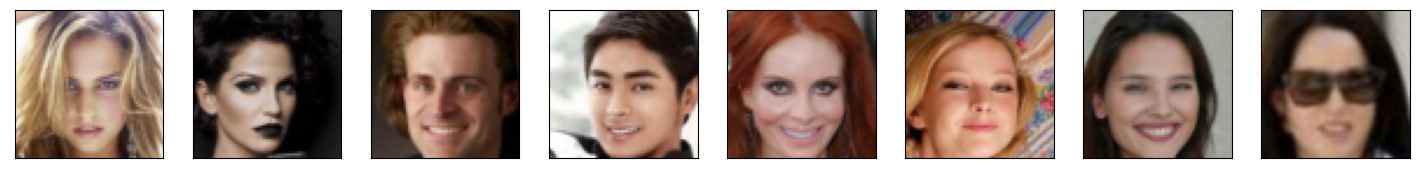

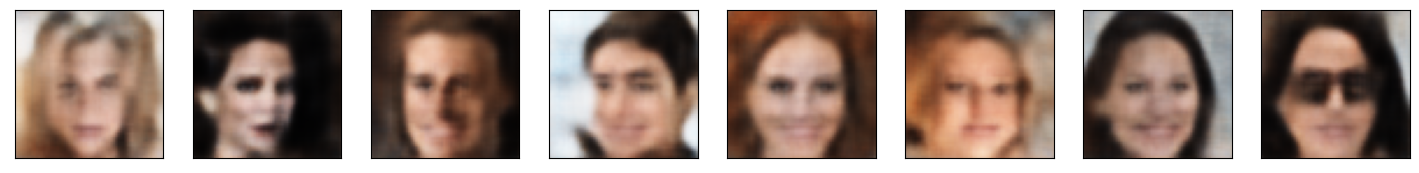

2001
commit_loss 0.001486244611442089
recon_loss 0.006073758937418461
2002
commit_loss 0.001424653921276331
recon_loss 0.006296630948781967
2003
commit_loss 0.0014233620604500175
recon_loss 0.006019780412316322
2004
commit_loss 0.0015106512000784278
recon_loss 0.00614816602319479
2005
commit_loss 0.0014725197106599808
recon_loss 0.005847403313964605
2006
commit_loss 0.0014033634215593338
recon_loss 0.005904054269194603
2007
commit_loss 0.0013043630169704556
recon_loss 0.005544701591134071
2008
commit_loss 0.0014863205142319202
recon_loss 0.005287918262183666
2009
commit_loss 0.0013742807786911726
recon_loss 0.006490437313914299
2010
commit_loss 0.0015452327206730843
recon_loss 0.005801138933748007
2011
commit_loss 0.001537378877401352
recon_loss 0.005899009294807911
2012
commit_loss 0.0015310847666114569
recon_loss 0.005737990140914917
2013
commit_loss 0.0014714908320456743
recon_loss 0.005830003879964352
2014
commit_loss 0.0013808500953018665
recon_loss 0.005906008183956146
2015
commi

2119
commit_loss 0.0013051878195255995
recon_loss 0.005580505356192589
2120
commit_loss 0.0013522296212613583
recon_loss 0.00597807951271534
2121
commit_loss 0.0012925933115184307
recon_loss 0.005031091161072254
2122
commit_loss 0.0015096953138709068
recon_loss 0.006745185703039169
2123
commit_loss 0.0013005719520151615
recon_loss 0.006178094074130058
2124
commit_loss 0.0012883611489087343
recon_loss 0.005783340893685818
2125
commit_loss 0.001548050669953227
recon_loss 0.005409495439380407
2126
commit_loss 0.001340858289040625
recon_loss 0.005520564969629049
2127
commit_loss 0.0013740176800638437
recon_loss 0.005525842308998108
2128
commit_loss 0.0013168230652809143
recon_loss 0.005707347299903631
2129
commit_loss 0.0014442047104239464
recon_loss 0.005765225738286972
2130
commit_loss 0.0014790586428716779
recon_loss 0.0058359913527965546
2131
commit_loss 0.0013327172491699457
recon_loss 0.005287403240799904
2132
commit_loss 0.0013593038311228156
recon_loss 0.005492274649441242
2133
com

commit_loss 0.0013193119084462523
recon_loss 0.005881012417376041
2236
commit_loss 0.0013502610381692648
recon_loss 0.00581309525296092
2237
commit_loss 0.0013725431635975838
recon_loss 0.005755317397415638
2238
commit_loss 0.001455468125641346
recon_loss 0.00626970361918211
2239
commit_loss 0.001467510825023055
recon_loss 0.005921698175370693
2240
commit_loss 0.00121269968803972
recon_loss 0.005998473148792982
2241
commit_loss 0.0014075104845687747
recon_loss 0.006178293377161026
2242
commit_loss 0.0013660391559824347
recon_loss 0.005747340153902769
2243
commit_loss 0.0013322217855602503
recon_loss 0.005730349104851484
2244
commit_loss 0.0013704419834539294
recon_loss 0.005683652125298977
2245
commit_loss 0.0014737257733941078
recon_loss 0.006050391122698784
2246
commit_loss 0.0013445679796859622
recon_loss 0.005711703561246395
2247
commit_loss 0.001558183692395687
recon_loss 0.0058756801299750805
2248
commit_loss 0.0013056981842964888
recon_loss 0.005343097262084484
2249
commit_loss 

2351
commit_loss 0.0015567843802273273
recon_loss 0.0056275250390172005
2352
commit_loss 0.0015486434567719698
recon_loss 0.00614408403635025
2353
commit_loss 0.0012679928913712502
recon_loss 0.005539211910218
2354
commit_loss 0.0013649784959852695
recon_loss 0.00588081032037735
2355
commit_loss 0.0014232564717531204
recon_loss 0.00602258276194334
2356
commit_loss 0.0013292378280311823
recon_loss 0.00594464223831892
2357
commit_loss 0.001199947902932763
recon_loss 0.005343676544725895
2358
commit_loss 0.0012780539691448212
recon_loss 0.005400029476732016
2359
commit_loss 0.00143075839150697
recon_loss 0.00593610992655158
2360
commit_loss 0.0013741198927164078
recon_loss 0.0053925286047160625
2361
commit_loss 0.001365268137305975
recon_loss 0.005656299646943808
2362
commit_loss 0.0013721126597374678
recon_loss 0.0060979751870036125
2363
commit_loss 0.001438793377019465
recon_loss 0.005649100989103317
2364
commit_loss 0.001397567568346858
recon_loss 0.0056123798713088036
2365
commit_loss

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, latent_temp=1)

            # Backward
            loss = 0
            for key in data.keys():
                if 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
            
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            x = data['x']
            y = data['y']
            
            plot(x)
            plot(y)
            
            def get_entropy(zi):
                # (N, L)
                zi_onehot = F.one_hot(zi, num_classes=hp.n_latents)
                # (L)
                probs = zi_onehot.sum(dim=0) / len(zi_onehot)
                entropy = torch.sum(-probs * (torch.log(torch.clamp(probs, 1e-8)) - np.log(2)))
                return entropy

            entropy = get_entropy(data['zi']).item()
            writer.add_scalar('entropy', entropy, step)
            
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')